<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)" data-toc-modified-id="Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Using percent served to convert from sentences to lengths of stay (LOS)</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Winter 2022. 
It uses the court data we scraped in October 2021 to model earned sentence credits policy in VA. Important note: this notebook can either disaggregate by rural/urban or by race. There's a variable in the preprocessing you can toggle, and you'll also have to make sure the yaml config is right for the one you're doing. Finally, at the bottom of the notebook, there's code to analyze the results either by rural/urban or by race. The two versions are just stacked one on top of the other, but only the one corresponding to the kind of simulation you ran will work at any given moment.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

In [15]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9869/110041657.py:1: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9869/110041657.py:1: DtypeWarning: Columns (18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([


In [16]:
cities = [
    'Suffolk Circuit Court',
    'Roanoke City Circuit Court',
    'York County/Poquoson Circuit Court',
    'Virginia Beach Circuit Court',
    'Winchester Circuit Court',
    'Salem Circuit Court',
    'Williamsburg/James City County Circuit Court',
    'Staunton Circuit Court',
    'Richmond City Circuit Court',
    'Radford Circuit Court',
    'Waynesboro Circuit Court',
    'Portsmouth Circuit Court',
    'Norfolk Circuit Court',
    'Petersburg Circuit Court',
    'Chesapeake Circuit Court',
    'Danville Circuit Court',
    'Martinsville Circuit Court',
    'Newport News Circuit Court',
    'Hopewell Circuit Court',
    'Buena Vista Circuit Court',
    'Bristol Circuit Court',
    'Charlottesville Circuit Court',
    'Colonial Heights Circuit Court',
    'Fredericksburg Circuit Court',
]
non_city_counties = [
    'Surry Circuit Court',
    'Prince George Circuit Court',
    'Shenandoah Circuit Court',
    'Rockbridge Circuit Court',
    'Warren Circuit Court',
    'Wythe Circuit Court',
    'Spotsylvania Circuit Court',
    'Roanoke County Circuit Court',
    'Page Circuit Court',
    'Lunenburg Circuit Court',
    'Southampton Circuit Court',
    'Smyth Circuit Court',
    'Wise Circuit Court',
    'Tazewell Circuit Court',
    'Richmond County Circuit Court',
    'Scott Circuit Court',
    'Sussex Circuit Court',
    'Prince William Circuit Court',
    'Russell Circuit Court',
    'Nelson Circuit Court',
    'Stafford Circuit Court',
    'Prince Edward Circuit Court',
    'Isle of Wight Circuit Court',
    'Rappahannock Circuit Court',
    'Westmoreland Circuit Court',
    'Rockingham Circuit Court',
    'Orange Circuit Court',
    'Powhatan Circuit Court',
    'Pulaski Circuit Court',
    'Washington Circuit Court',
    'Nottoway Circuit Court',
    'Montgomery Circuit Court',
    'Northumberland Circuit Court',
    'Louisa Circuit Court',
    'Northampton Circuit Court',
    'Middlesex Circuit Court',
    'Loudoun Circuit Court',
    'Pittsylvania Circuit Court',
    'Mecklenburg Circuit Court',
    'Lee Circuit Court',
    'Greensville Circuit Court',
    'Buckingham Circuit Court',
    'Augusta Circuit Court',
    'Mathews Circuit Court',
    'Lancaster Circuit Court',
    'Patrick Circuit Court',
    'King William Circuit Court',
    'New Kent Circuit Court',
    'Greene Circuit Court',
    'Buchanan Circuit Court',
    'Grayson Circuit Court',
    'Arlington Circuit Court',
    'Highland Circuit Court',
    'Henry Circuit Court',
    'King George Circuit Court',
    'Madison Circuit Court',
    'Goochland Circuit Court',
    'Fluvanna Circuit Court',
    'Bath Circuit Court',
    'Accomack Circuit Court',
    'Chesterfield Circuit Court',
    'Bedford Circuit Court',
    'Campbell Circuit Court',
    'Dickenson Circuit Court',
    'Albemarle Circuit Court',
    'Dinwiddie Circuit Court',
    'Bland Circuit Court',
    'Alleghany Circuit Court',
    'Botetourt Circuit Court',
    'Amelia Circuit Court',
    'Caroline Circuit Court',
    'Amherst Circuit Court',
    'Carroll Circuit Court',
    'Appomattox Circuit Court',
    'Brunswick Circuit Court',
    'Charles City Circuit Court',
    'Charlotte Circuit Court',
    'Essex Circuit Court',
    'Hampton Circuit Court',
    'Fauquier Circuit Court',
    'Clarke Circuit Court',
    'Floyd Circuit Court',
    'Craig Circuit Court',
    'Culpeper Circuit Court',
    'Frederick Circuit Court',
    'Cumberland Circuit Court',
    'Giles Circuit Court',
    'Gloucester Circuit Court',
    'Halifax Circuit Court',
    'Hanover Circuit Court',
    'Lynchburg Circuit Court',
    'Henrico Circuit Court',
    'Clifton Forge Circuit Court'
]

unclears = [
    'Franklin Circuit Court',
]

def city(county):
    if county in cities:
        return 'yes'
    if county in non_city_counties:
        return 'no'    


sdc_data['city'] = sdc_data.county.apply(city)

11672


In [ ]:
print(f'dropping {len(sdc_data[sdc_data.city.isnull()])} of {len(sdc_data)} datapoints.')
sdc_data = sdc_data[sdc_data.city.notnull()]

In [17]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [18]:
#NO DISAGGREGATION

scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9869/1652057997.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


,time_step,crime_type,total_population,compartment,outflow_to
4903,-107,ARSON,14.976888,pretrial,prison
4904,-107,ASSAULT,299.537761,pretrial,prison
4905,-107,BURGLARY,138.120190,pretrial,prison
4906,-107,CONSPIRACY,29.953776,pretrial,prison
4907,-107,DRUG_OTHER,83.204934,pretrial,prison


In [19]:
# Create transitions data
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data.loc[transitions_data.compartment_duration > 12 * 50, 'compartment_duration'] = 12 * 50
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type'
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    crime_recidivism = recidivism_transitions.copy()
    total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
    crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
    crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - crime_specific_total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime_type'] = crime

    transitions_data = transitions_data.append(crime_recidivism)

    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime_type == crime, 'total_population'
    ] /= 1 + crime_specific_total_recidivism

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types),
    'total_population': [1] * len(crime_types),
    'compartment': ['release_full'] * len(crime_types),
    'outflow_to': ['release_full'] * len(crime_types),
    'crime_type': crime_types,
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,total_population,compartment,outflow_to
0,1.0,ARSON,141.0,prison,release
1,1.0,ASSAULT,5998.0,prison,release
2,1.0,BURGLARY,939.0,prison,release
3,1.0,CONSPIRACY,279.0,prison,release
4,1.0,DRUG_OTHER,1563.0,prison,release


In [20]:
# can either make this 'city' or 'race'
disaggregation = 'city'

if disaggregation == 'race':
    sdc_data = sdc_data.rename({'Race': 'race'}, axis=1)
    sdc_data.loc[sdc_data.race.apply(lambda x: x not in ['White', 'Black']), 'race'] = 'Other'


scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type', disaggregation]).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9869/1774938306.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


,time_step,crime_type,city,total_population,compartment,outflow_to
8800,-107,ARSON,no,13.312789,pretrial,prison
8801,-107,ARSON,yes,1.664099,pretrial,prison
8802,-107,ASSAULT,no,174.730360,pretrial,prison
8803,-107,ASSAULT,yes,124.807400,pretrial,prison
8804,-107,BURGLARY,no,86.533131,pretrial,prison


In [21]:
# Create transitions data
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data.loc[transitions_data.compartment_duration > 12 * 50, 'compartment_duration'] = 12 * 50
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type', disaggregation
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    for d in sdc_data[disaggregation].unique():
        crime_recidivism = recidivism_transitions.copy()
        total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
        crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
        crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
        crime_recidivism = crime_recidivism.append({
            'compartment_duration': 36,
            'total_population': 1 - crime_specific_total_recidivism,
            'compartment': 'release',
            'outflow_to': 'release_full',
        }, ignore_index=True)
        crime_recidivism[disaggregation] = d
        crime_recidivism['crime_type'] = crime

        transitions_data = transitions_data.append(crime_recidivism)
    
        # adjust outflows so we're not double counting recidivism
        outflows_data.loc[
            (outflows_data.crime_type == crime) & (outflows_data[disaggregation] == d), 'total_population'
        ] /= 1 + crime_specific_total_recidivism

for d in sdc_data[disaggregation].unique():
    transitions_data = transitions_data.append(pd.DataFrame({
        'compartment_duration': [24] * len(crime_types),
        'total_population': [1] * len(crime_types),
        'compartment': ['release_full'] * len(crime_types),
        'outflow_to': ['release_full'] * len(crime_types),
        disaggregation: [d] * len(crime_types),
        'crime_type': crime_types,
    }), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,city,total_population,compartment,outflow_to
0,1.0,ARSON,no,93.0,prison,release
1,1.0,ARSON,yes,48.0,prison,release
2,1.0,ASSAULT,no,3504.0,prison,release
3,1.0,ASSAULT,yes,2494.0,prison,release
4,1.0,BURGLARY,no,611.0,prison,release


In [22]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [23]:
if disaggregation == 'city':
    outflows_data = outflows_data.rename({'city': 'age'}, axis=1)
    transitions_data = transitions_data.rename({'city': 'age'}, axis=1)

In [24]:
simulation_tag = "VA_ETC"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/policy_configurations/ETC_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
1it [00:04,  4.58s/it]
1it [00:04,  4.12s/it]
1it [00:04,  4.39s/it]


## Using percent served to convert from sentences to lengths of stay (LOS)
This disaggregates by the crime types given to us in the LOS table. You may need to disaggregate differently for whatever policy you're working on, you'll have to think about how to capture the average LOS in whatever categories you work with.

In [54]:
a = sdc_data.groupby(['city', 'crime_type']).count().max(axis=1).unstack('crime_type')
a.loc['no'] /= 587615
a.loc['yes'] /=292617
a

crime_type,ARSON,ASSAULT,BURGLARY,CAPITAL_MURDER,CONSPIRACY,DRUG_OTHER,DRUG_POSSESSION,DRUG_SALE,DWI,FIRST_DEGREE_MURDER,KIDNAPPING,LARCENY,MANSLAUGHTER,OTHER_MURDER,RAPE,ROBBERY,SECOND_DEGREE_MURDER,SEX_OFFENSE,WEAPON
city,,,,,,,,,,,,,,,,,,,
no,0.004239,0.084840,0.030578,0.000434,0.004767,0.033912,0.088241,0.066334,0.059736,0.000657,0.010454,0.145582,0.001741,0.002786,0.016953,0.011273,0.000250,0.004823,0.028046
yes,0.003599,0.093754,0.026116,0.000390,0.004272,0.025819,0.128205,0.043993,0.045524,0.000926,0.010085,0.147401,0.000916,0.003250,0.012706,0.018495,0.000277,0.003865,0.027562


In [51]:
sdc_data.groupby('city').count().max(axis=1)

city
no     587615
yes    292617
dtype: int64

# Modeling

In [25]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/ETC_model_inputs.yaml'
)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:00<00:00, 6661.73rows/s]
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 4668 results


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4980/4980 [00:00<00:00, 5584.66rows/s]


transitions_data returned 4980 results


Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 110.59rows/s]
crime_type            compartment  outflow_to
CAPITAL_MURDER        pretrial     prison        39.007092
SECOND_DEGREE_MURDER  pretrial     prison        48.936170
dtype: float64%


total_population_data returned 34 results


initialization time:  431.5811460018158


simulation_time:  492.04417395591736


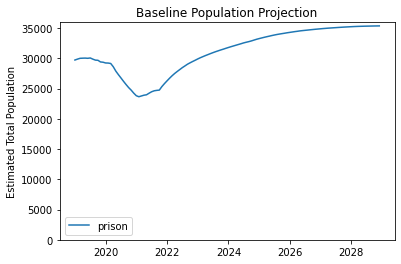

In [40]:
spark_sim.simulate_baseline(['prison'])

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/validator.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=fig_size)


[<AxesSubplot:title={'center':'simulation_group: ARSONBlack\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ARSONOther\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ARSONWhite\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASSAULTBlack\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASSAULTOther\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASSAULTWhite\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARYBlack\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARYOther\ncompartment: pretrial\noutflow_to: pri

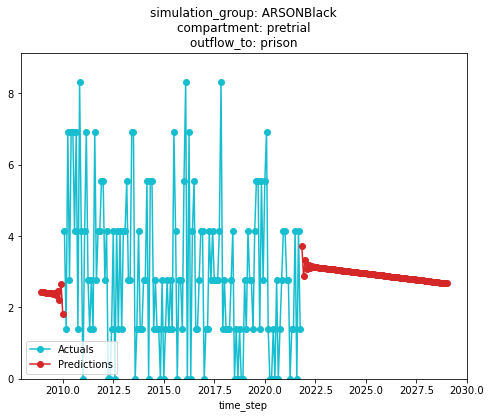

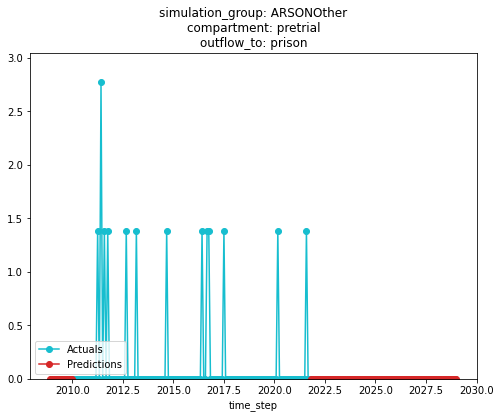

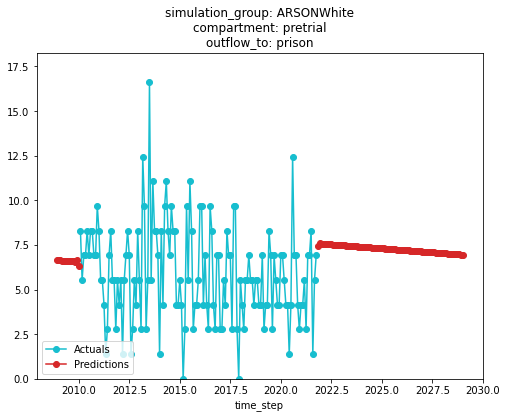

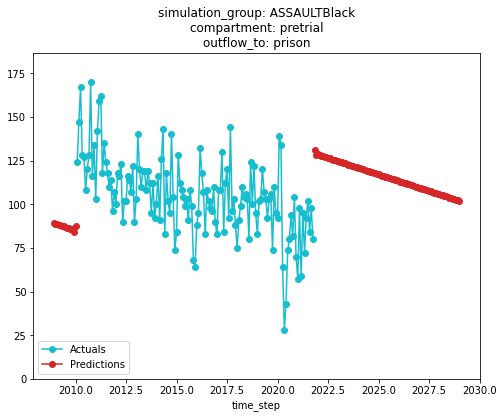

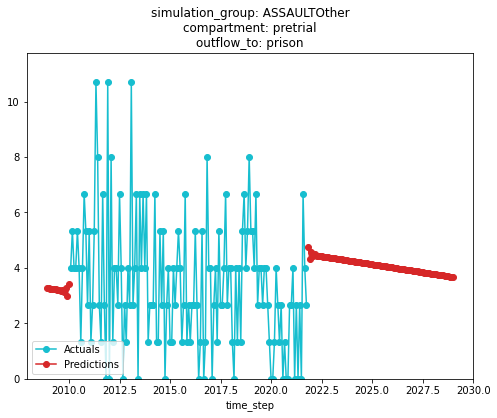

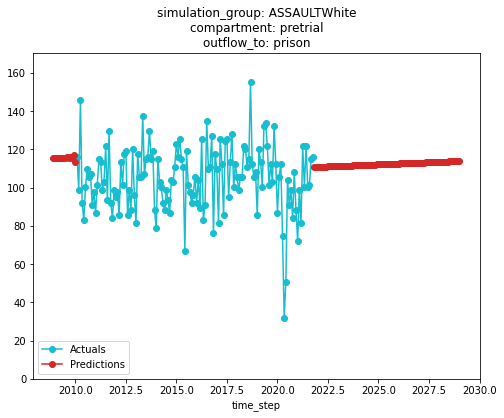

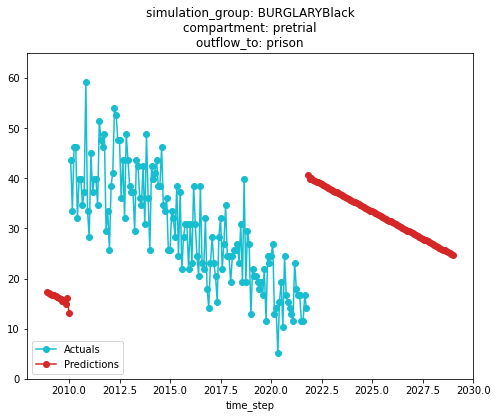

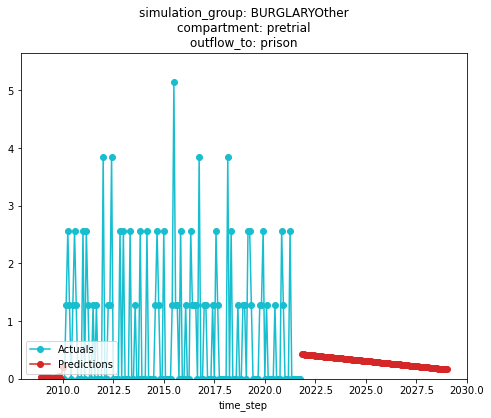

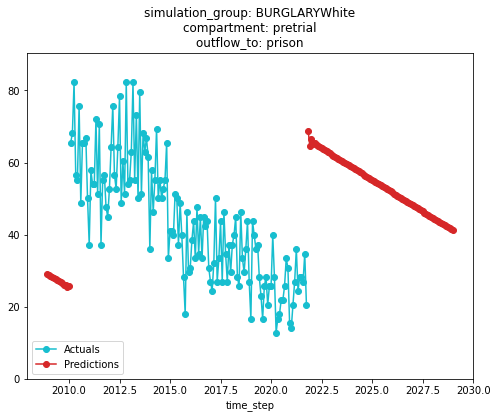

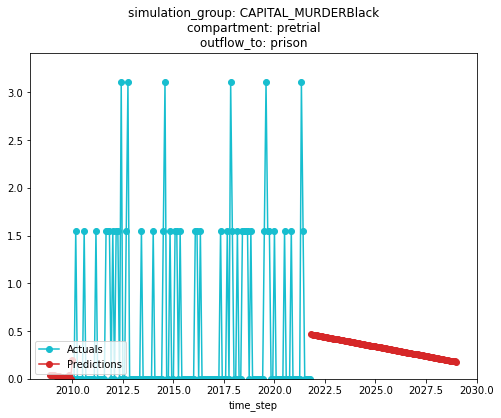

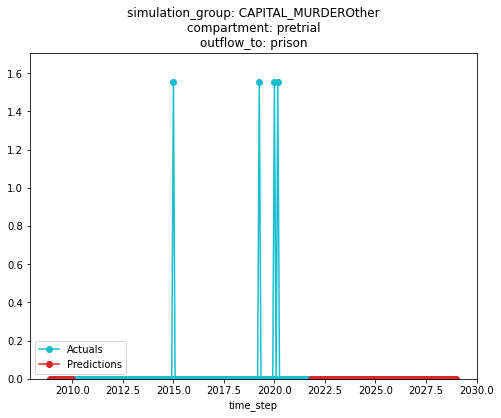

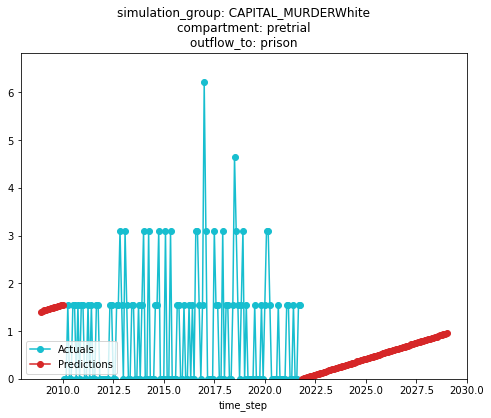

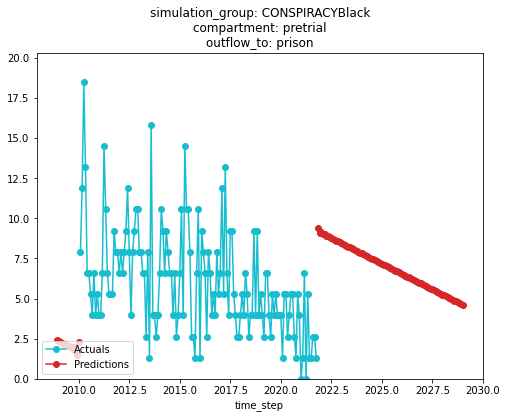

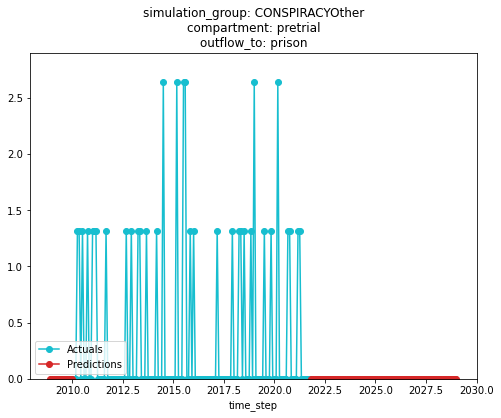

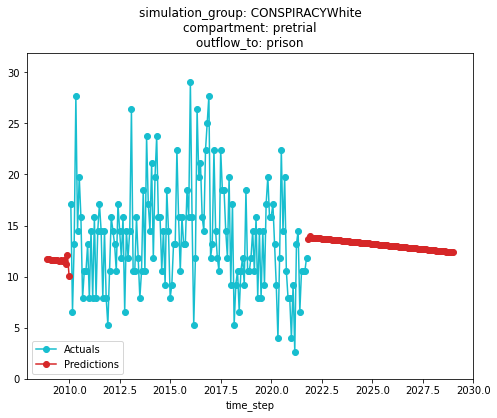

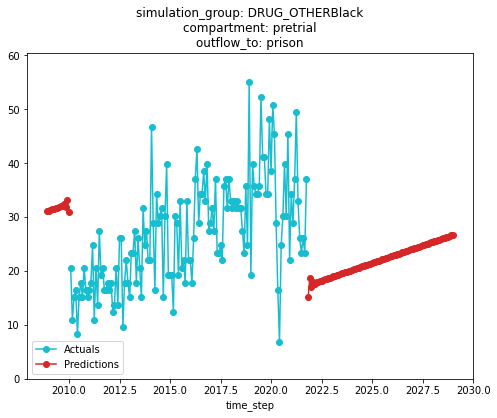

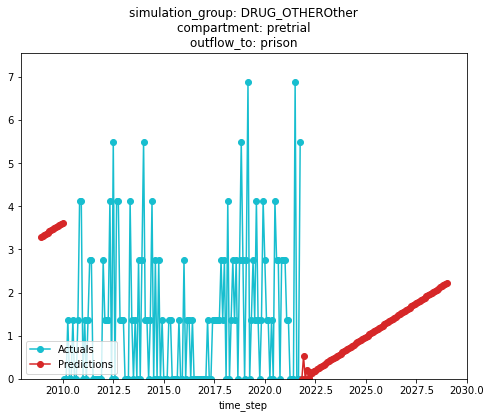

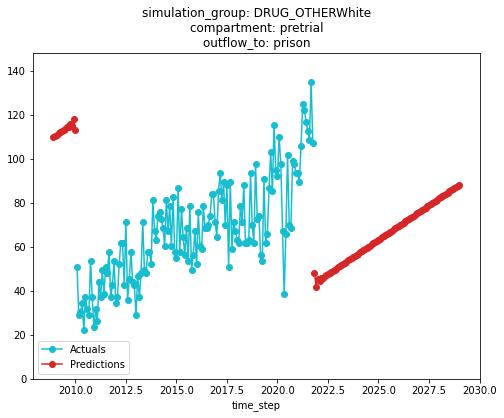

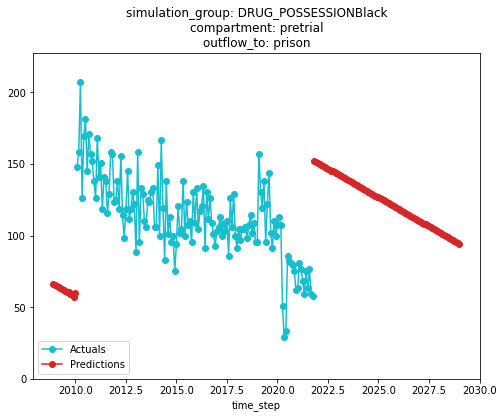

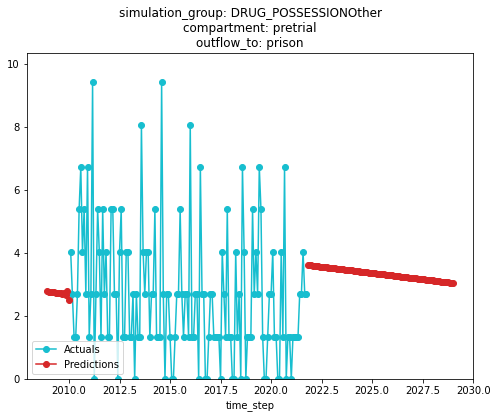

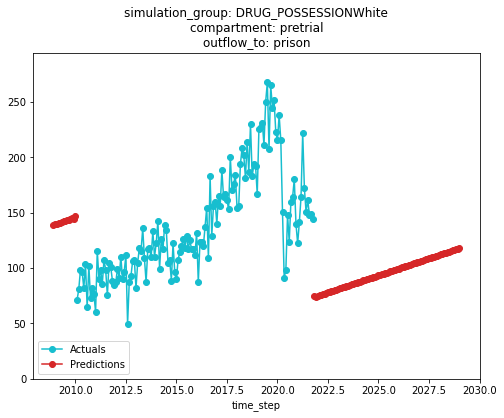

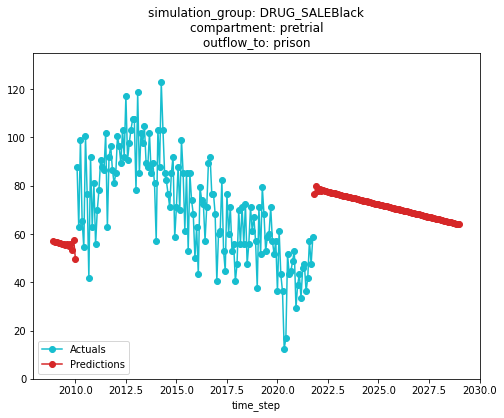

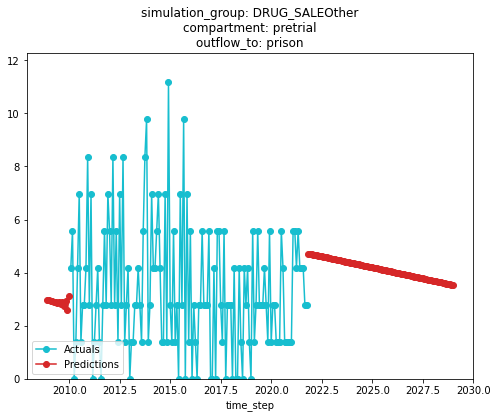

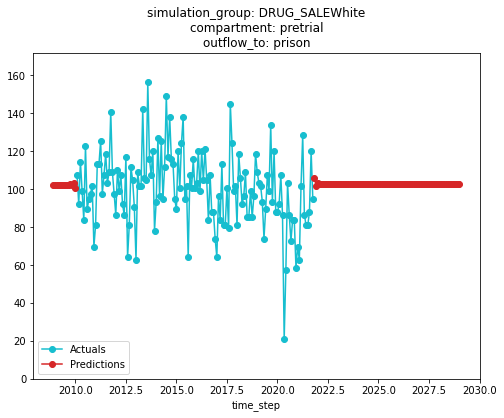

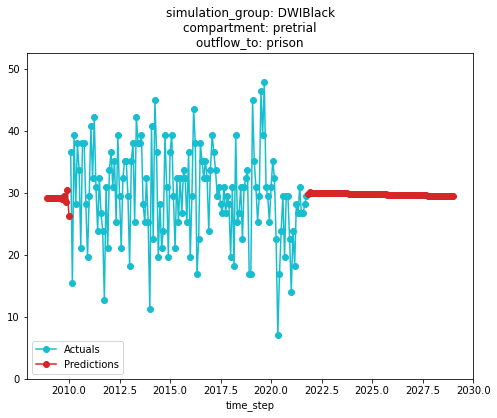

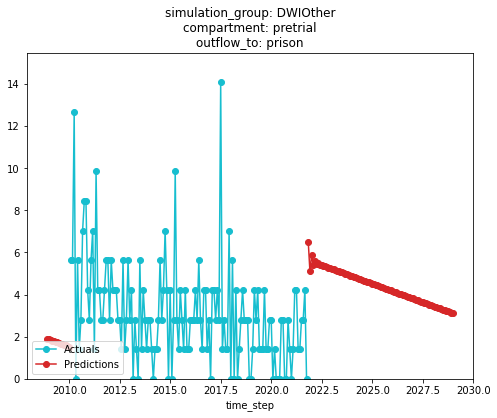

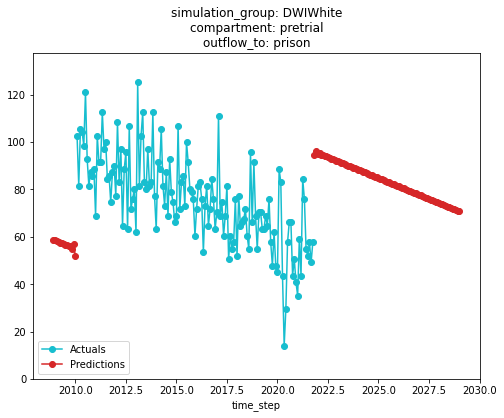

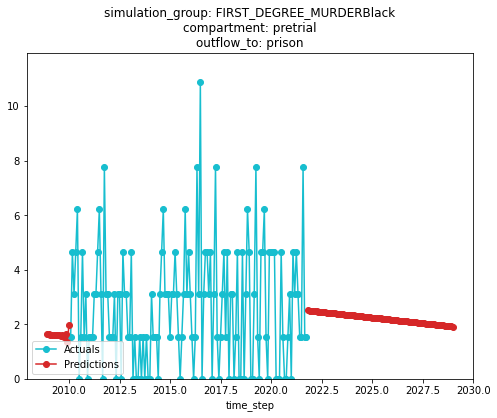

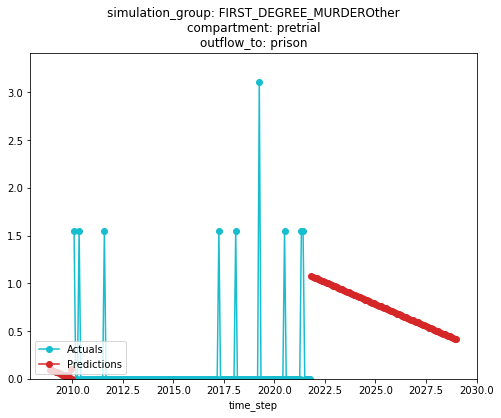

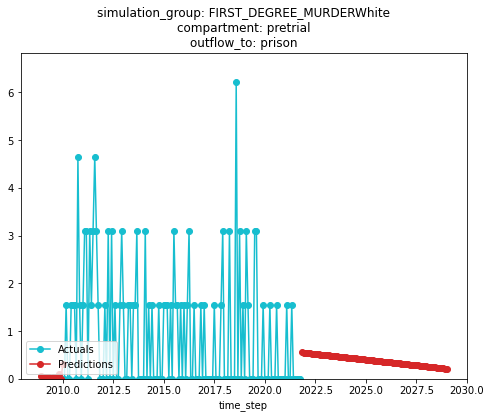

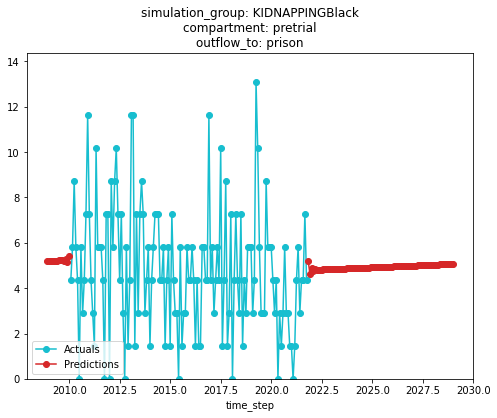

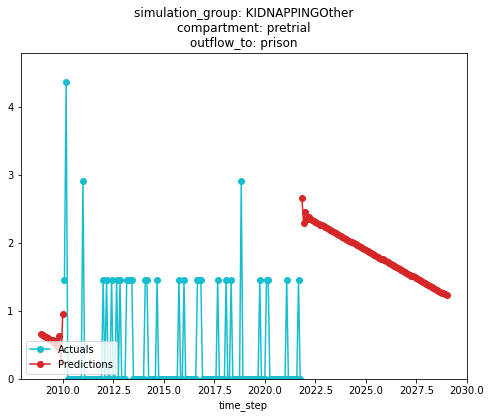

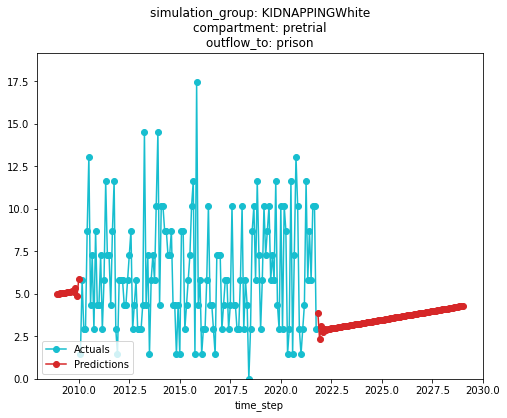

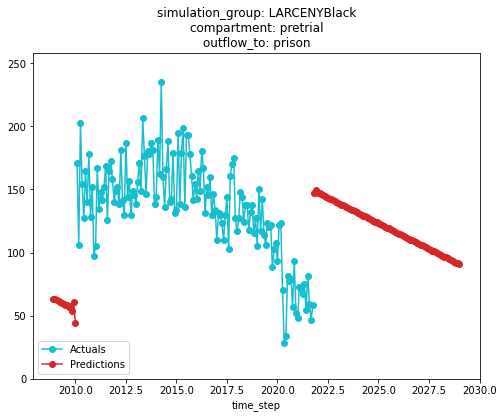

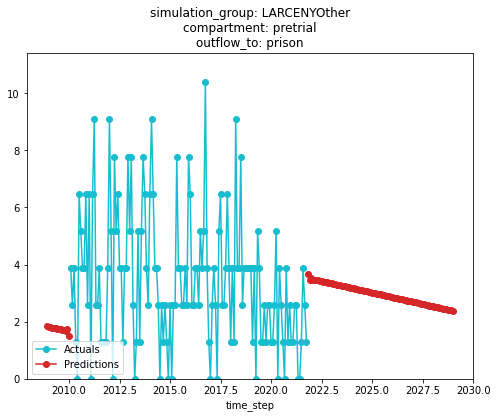

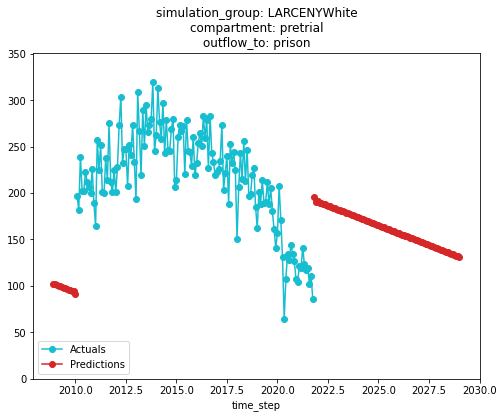

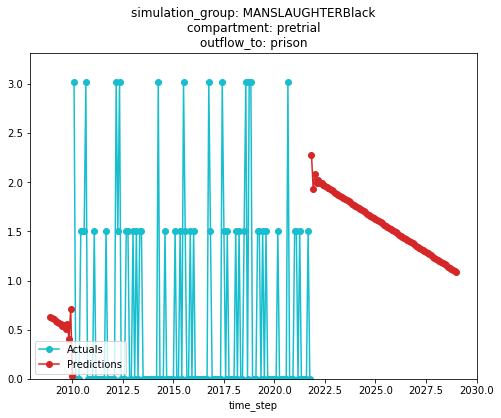

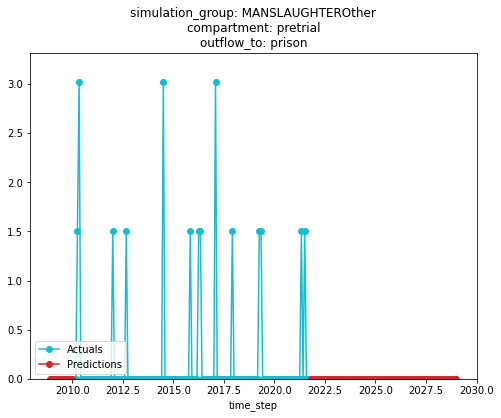

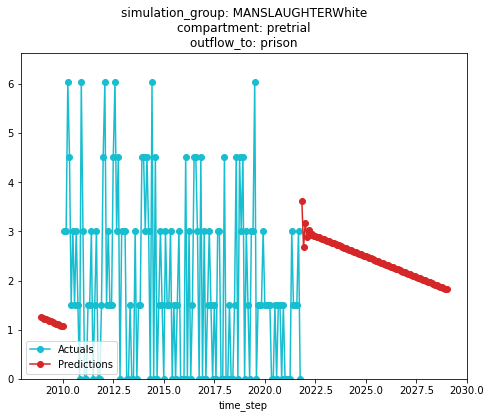

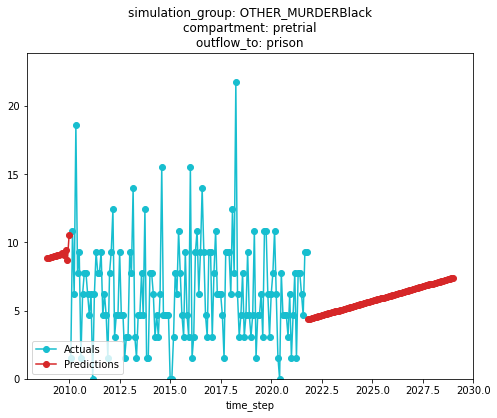

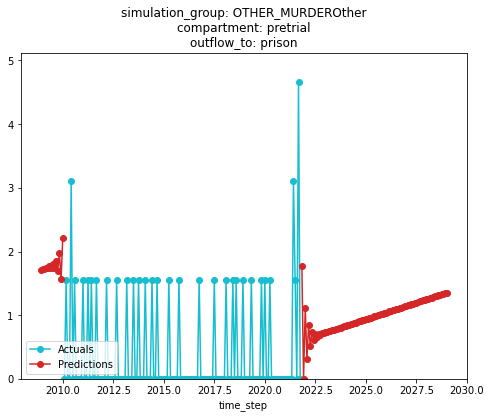

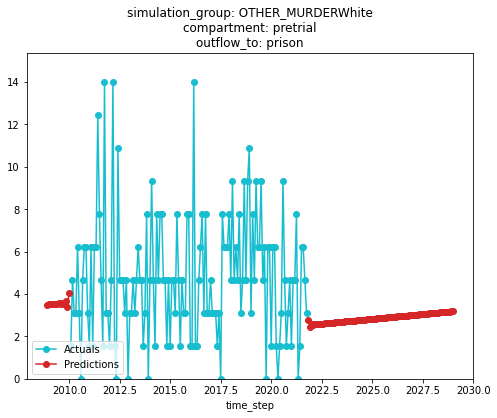

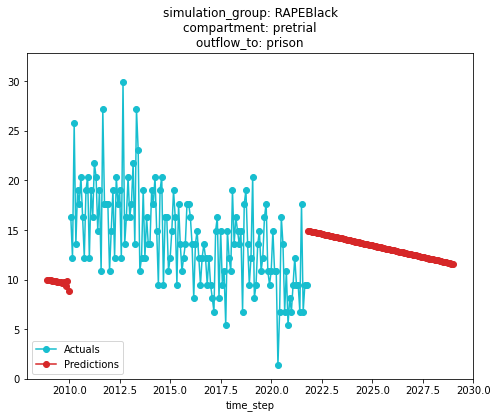

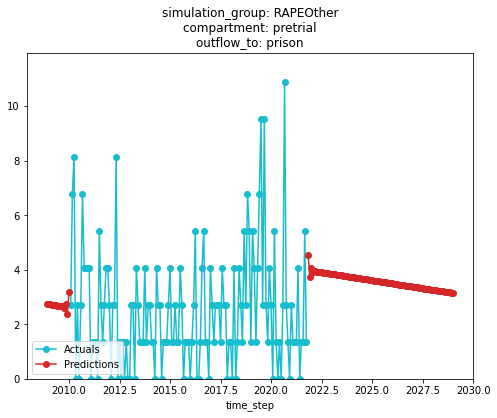

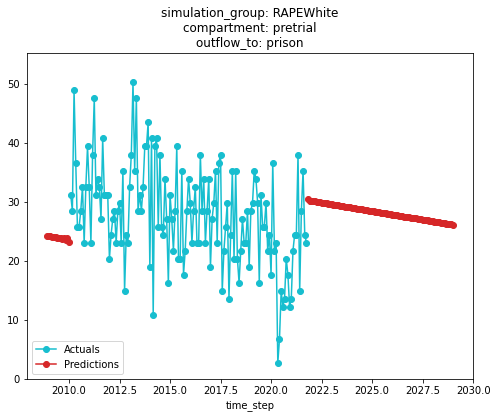

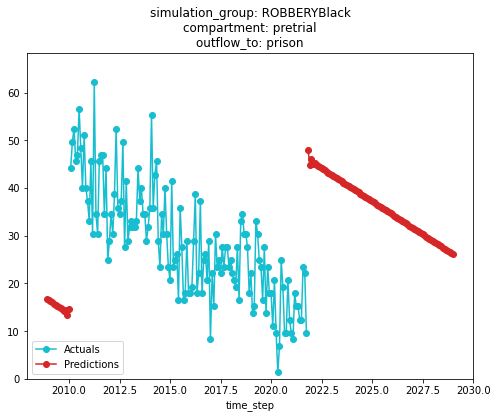

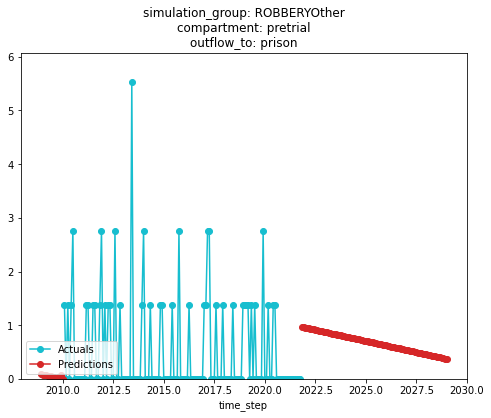

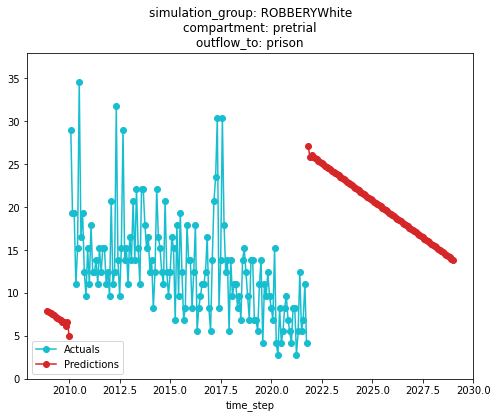

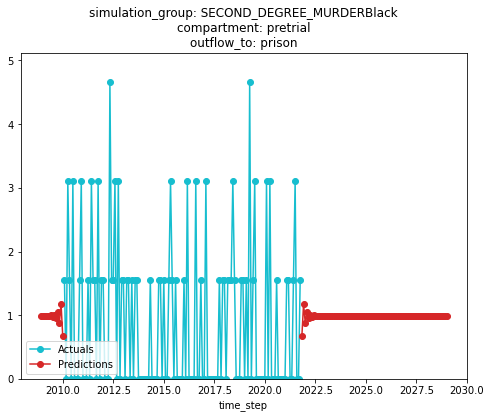

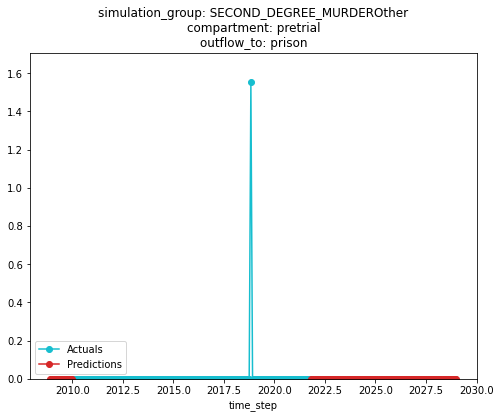

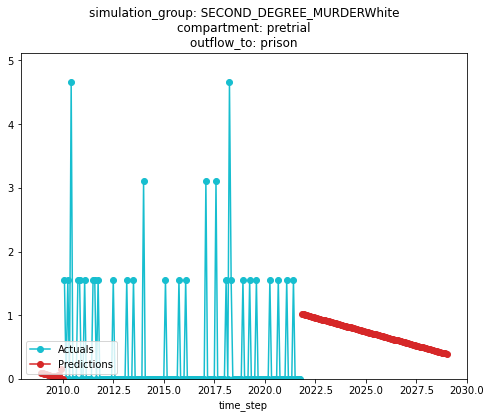

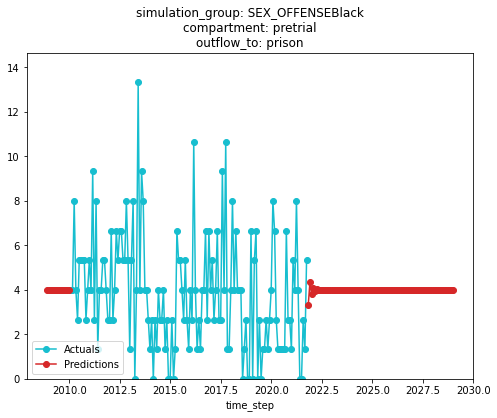

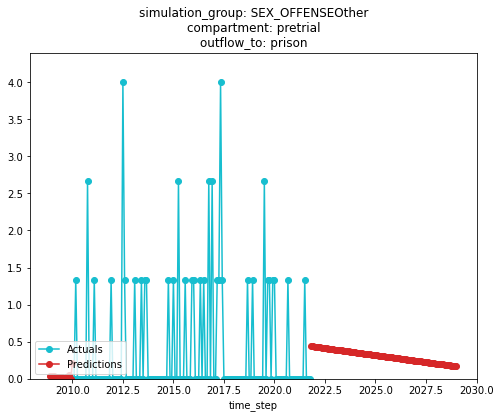

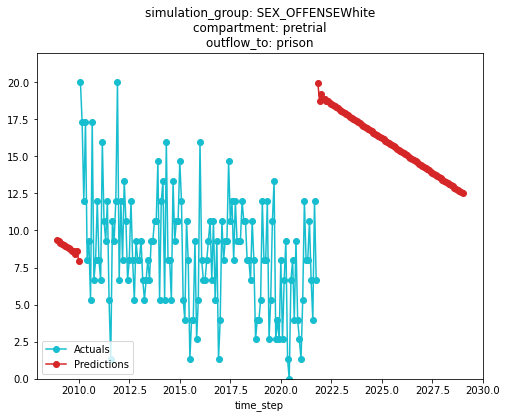

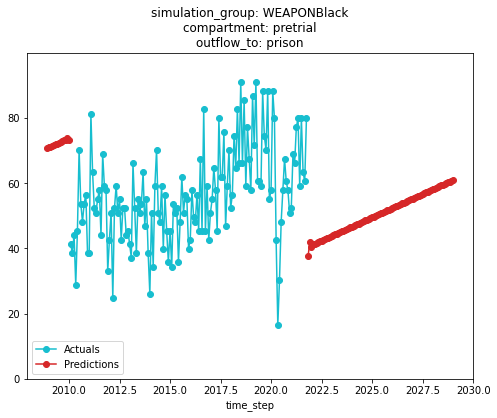

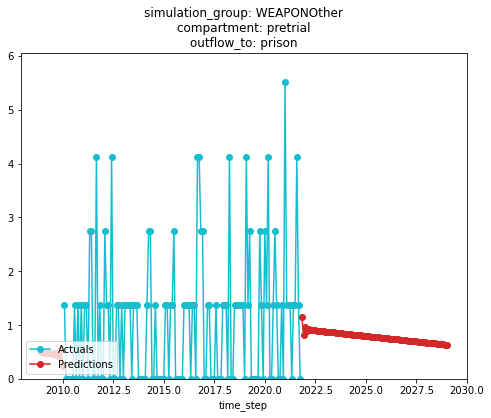

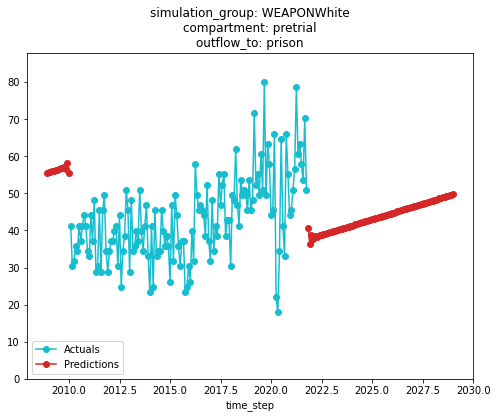

In [42]:
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group=True)

In [26]:
# not actually using this yet, but I suspect moving people down ETC levels will be a more accurate handling
# for our next draft.
ETC_LEVEL_BY_CRIME = pd.DataFrame({
    'CONSPIRACY': {1:27, 2: 5, 3: 12, 4:7},
    'DRUG_POSSESSION': {1:574, 2:78, 3:177, 4:171},
    'DRUG_SALE': {1:1415, 2:245, 3:629, 4:458},
    'DRUG_OTHER': {1:1989, 2:323, 3:806, 4:629},
    'KIDNAPPING': {1:641, 2:203, 3:430, 4:304},
    'MANSLAUGHTER': {1:175, 2:44, 3:122, 4:96},
    'LARCENY': {1:1289, 2:190, 3:447, 4:591},
    'WEAPON': {1:346, 2:45, 3:100, 4:158},
    'ASSAULT': {1:1391, 2:354, 3:685, 4:728},
    'ROBBERY': {1:1491, 2:488, 3:1049, 4:1014},
    'BURGLARY': {1:740, 2:165, 3:413, 4:476},
    'DWI': {1: 101, 2: 14, 3: 28, 4:24},
    'RAPE': {1:1355, 2:304, 3:917, 4:405},
    'SEX_OFFENSE': {1:343, 2:60, 3:180, 4:80},
    'ARSON': {1:40, 2:13, 3:14, 4:26},
    'FIRST_DEGREE_MURDER': {1:868, 2:288, 3:534, 4:313},
    'SECOND_DEGREE_MURDER': {1:296, 2: 109, 3:224, 4:148},
    'OTHER_MURDER': {1:1327, 2:432, 3:833, 4:498},
    'CAPITAL_MURDER': {1:163, 2:35, 3:75, 4:37}
}).transpose()


# Note that I just use 0.85 as the new LOS in all cases. This is because we talked about doubling time off,
# but VA has a sentence reduction cap at 15%, so that'd just push everyone up to the cap.
def increase_ETCs(crime):
    crime_avg_LOS = LOS_BY_CRIME[crime]
    crime_levels = ETC_LEVEL_BY_CRIME.loc[crime]
    crime_total_count = sum(list(crime_levels.values))
    
    
# If ETC were truly the only way to get time off your sentence, this would work. This calculates a
# "utilization factor," i.e. the amount of maximal ETC the average person is actually earning. However, that
# factor turns out to be greater than 1, indicating that there are other ways to earn time off and also probably
# that people basically earn 100% of possible ETC. Thus I switched to the methodology below, which assumes 100%.

#     utilization_factor = (1 - crime_avg_LOS) * crime_total_count / (
#         (4.5 / 34.5) * crime_levels[1] + (3/33) * crime_levels[2] + (1.5/31.5) * crime_levels[3]
#     )

#     new_level_LOS = {
#         1: max(0.85, 1 - 15 / 45 * utilization_factor),
#         2: max(0.85, 1 - 10 / 40 * utilization_factor),
#         3: max(0.85, 1 - 5 / 35 * utilization_factor),
#         4: 1
#     }
    
    
    non_ETC_LOS_factor = crime_avg_LOS * crime_total_count / (
        (30 / 34.5) * crime_levels[1] + (30/33) * crime_levels[2] + (30/31.5) * crime_levels[3] + crime_levels[4]
    )
    
#     new_level_LOS = {
#         1: max(0.85, (1 - 15 / 45) * non_ETC_LOS_factor),
#         2: max(0.85, (1 - 10 / 40) * non_ETC_LOS_factor),
#         3: max(0.85, (1 - 5 / 35) * non_ETC_LOS_factor),
#         4: max(0.85, 1 * non_ETC_LOS_factor)
#     }
    new_level_LOS = {
        1: (1 - 15 / 45) * non_ETC_LOS_factor,
        2: (1 - 7.5 / 37.5) * non_ETC_LOS_factor,
        3: (1 - 3.5 / 33.5) * non_ETC_LOS_factor,
        4: 1 * non_ETC_LOS_factor
    }
    
    new_LOS = sum([crime_levels[i] * new_level_LOS[i] for i in range(1,5)]) / crime_total_count
    
#     print(crime, utilization_factor)
    print(crime, non_ETC_LOS_factor)
    
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'reduction_size': [(LOS_BY_CRIME[crime] - new_LOS) / LOS_BY_CRIME[crime]], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='*',
                   retroactive=True)

policy_list = []
for crime in crime_types:
    policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
                                                   spark_compartment='prison',
                                                   sub_population={'crime_type': crime},
                                                   policy_ts=36,
                                                   apply_retroactive=True))
# if disaggregation == 'race':
#     for crime in crime_types:
#         policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
#                                                spark_compartment='prison',
#                                                sub_population={'crime_type': crime, 'race': 'Black'},
#                                                policy_ts=36,
#                                                apply_retroactive=True))
#         policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
#                                                spark_compartment='prison',
#                                                sub_population={'crime_type': crime, 'race': 'White'},
#                                                policy_ts=36,
#                                                apply_retroactive=True))
#         policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
#                                                spark_compartment='prison',
#                                                sub_population={'crime_type': crime, 'race': 'Other'},
#                                                policy_ts=36,
#                                                apply_retroactive=True))

# if disaggregation == 'city':
#     for crime in crime_types:
#         policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
#                                                spark_compartment='prison',
#                                                sub_population={'crime_type': crime, 'age': 'yes'},
#                                                policy_ts=36,
#                                                apply_retroactive=True))
#         policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
#                                                spark_compartment='prison',
#                                                sub_population={'crime_type': crime, 'age': 'no'},
#                                                policy_ts=36,
#                                                apply_retroactive=True))


test_results = spark_sim.simulate_policy(policy_list, 'prison')

CONSPIRACY 0.9870127633194358
DRUG_POSSESSION 0.9861358812753698
DRUG_SALE 0.987086467431631
DRUG_OTHER 0.987200022047929
KIDNAPPING 0.9898681085993776
MANSLAUGHTER 0.9899289122821391
LARCENY 0.988143534704725
WEAPON 0.9871066632208532
ASSAULT 0.9891239991405415
ROBBERY 0.9907903471388435
BURGLARY 0.9893472030958566
DWI 0.9861855178783021
RAPE 0.9882281977423873
SEX_OFFENSE 0.9875298570227083
ARSON 0.9891530418250951
FIRST_DEGREE_MURDER 0.9883301363917156
SECOND_DEGREE_MURDER 0.9893600148305318
OTHER_MURDER 0.9886349721590588
CAPITAL_MURDER 0.9872125383212155


KeyboardInterrupt: 

In [122]:
# maybe don't run this one yourself, no need to spam our output database :)
simulation_tag = 'VA_ETC_jan_8_2'
outputs = spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [47]:
spark_sim.simulator.pop_simulations['policy'].get_population_projections()

,compartment,time_step,total_population,simulation_group
-121,prison,-121,2.438307,ARSONBlack
-120,prison,-120,4.686645,ARSONBlack
-119,prison,-119,6.816615,ARSONBlack
-118,prison,-118,8.835751,ARSONBlack
-117,prison,-117,10.791786,ARSONBlack
...,...,...,...,...
115,release_full,115,6887.437561,WEAPONWhite
116,release_full,116,6931.798905,WEAPONWhite
117,release_full,117,6975.247309,WEAPONWhite
118,release_full,118,7018.883882,WEAPONWhite


In [ ]:
def city(simulation_group):
    if simulation_group[-3:] == 'yes':
        return 'yes'
    return 'no'

def race(simulation_group):
    return simulation_group[-5:]


policy_outputs = spark_sim.simulator.pop_simulations['policy'].get_population_projections()
policy_outputs = policy_outputs[
    (policy_outputs.compartment == 'prison') & (policy_outputs.time_step == (36 + 5 * 12))
]

disaggregation = 'race'
# policy_outputs['city'] = policy_outputs.simulation_group.apply(city)
policy_outputs['race'] = policy_outputs.simulation_group.apply(race)
policy_outputs = policy_outputs.groupby(disaggregation).total_population.sum()

baseline_outputs = spark_sim.simulator.pop_simulations['control'].get_population_projections()
baseline_outputs = baseline_outputs[
    (baseline_outputs.compartment == 'prison') & (baseline_outputs.time_step == (36 + 5 * 12))
]
# baseline_outputs['city'] = baseline_outputs.simulation_group.apply(city)
baseline_outputs['race'] = baseline_outputs.simulation_group.apply(race)
baseline_outputs = baseline_outputs.groupby(disaggregation).total_population.sum()

urban_impacts = pd.DataFrame()

urban_impacts['total'] = baseline_outputs - policy_outputs
urban_impacts['per_prison_capita'] = (baseline_outputs - policy_outputs) / baseline_outputs
urban_impacts['pct'] = urban_impacts.total / urban_impacts.total.sum() * 100
urban_impacts['baseline_breakdown'] = baseline_outputs / baseline_outputs.sum() * 100
urban_impacts['policy_breakdown'] = policy_outputs / policy_outputs.sum() * 100
urban_impacts

In [ ]:
race = sdc_data[sdc_data.time_step > -108].groupby('race').agg({'compartment_duration': 'sum'}).max(axis=1)
race = race / race.sum() * 100
race['Other'] = 100 - race[['Black', 'White']].sum()
race = race[['White', 'Black', 'Other']]

virginia_population = pd.Series({
    'White': 0.6763,
    'Black': 0.1918,
    'Other': 0.1319
})

per_capita = race / virginia_population
per_capita / per_capita.sum() * 100

per_capita_impact = urban_impacts.total / virginia_population
per_capita_impact / per_capita_impact.sum() * 100

In [91]:
def city(simulation_group):
    if simulation_group[-3:] == 'yes':
        return 'yes'
    return 'no'

def race(simulation_group):
    return simulation_group[-5:]


policy_outputs = spark_sim.simulator.pop_simulations['policy'].get_population_projections()
policy_outputs = policy_outputs[
    (policy_outputs.compartment == 'prison') & (policy_outputs.time_step == (36 + 5 * 12))
]

disaggregation = 'city'
policy_outputs['city'] = policy_outputs.simulation_group.apply(city)
# policy_outputs['race'] = policy_outputs.simulation_group.apply(race)
policy_outputs = policy_outputs.groupby(disaggregation).total_population.sum()

baseline_outputs = spark_sim.simulator.pop_simulations['control'].get_population_projections()
baseline_outputs = baseline_outputs[
    (baseline_outputs.compartment == 'prison') & (baseline_outputs.time_step == (36 + 5 * 12))
]
baseline_outputs['city'] = baseline_outputs.simulation_group.apply(city)
# baseline_outputs['race'] = baseline_outputs.simulation_group.apply(race)
baseline_outputs = baseline_outputs.groupby(disaggregation).total_population.sum()

urban_impacts = pd.DataFrame()

urban_impacts['total'] = baseline_outputs - policy_outputs
urban_impacts['per_prison_capita'] = (baseline_outputs - policy_outputs) / baseline_outputs
urban_impacts['pct'] = urban_impacts.total / urban_impacts.total.sum() * 100
urban_impacts['baseline_breakdown'] = baseline_outputs / baseline_outputs.sum() * 100
urban_impacts['policy_breakdown'] = policy_outputs / policy_outputs.sum() * 100
urban_impacts

<ipython-input-91-856e021d17b8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_outputs['city'] = policy_outputs.simulation_group.apply(city)
<ipython-input-91-856e021d17b8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_outputs['city'] = baseline_outputs.simulation_group.apply(city)


,total,per_prison_capita,pct,baseline_breakdown,policy_breakdown
city,,,,,
no,565.446925,0.025531,64.861036,63.770929,63.742861
yes,306.335207,0.024347,35.138964,36.229071,36.257139


In [95]:
circuit_populations = {
    'Suffolk Circuit Court': 94324,
    'Roanoke City Circuit Court': 100011,
    'York County/Poquoson Circuit Court': (70045 + 12460),
    'Virginia Beach Circuit Court': 459470,
    'Winchester Circuit Court': 2812,
    'Salem Circuit Court': 25346,
    'Williamsburg/James City County Circuit Court': (78254 + 15425 ),
    'Staunton Circuit Court': 25750,
    'Richmond City Circuit Court': 226610,
    'Radford Circuit Court': 16070,
    'Waynesboro Circuit Court': 22196,
    'Portsmouth Circuit Court': 97915,
    'Norfolk Circuit Court': 238005,
    'Petersburg Circuit Court': 33458,
    'Chesapeake Circuit Court': 249422,
    'Danville Circuit Court': 42590,
    'Martinsville Circuit Court': 13485,
    'Newport News Circuit Court': 186247,
    'Hopewell Circuit Court': 23033,
    'Buena Vista Circuit Court': 6641,
    'Bristol Circuit Court': 17219,
    'Charlottesville Circuit Court': 46553,
    'Colonial Heights Circuit Court': 18170,
    'Fredericksburg Circuit Court': 27982,
    'Surry Circuit Court': 6561,
    'Prince George Circuit Court': 43010,
    'Shenandoah Circuit Court': 44186,
    'Rockbridge Circuit Court': 22650,
    'Warren Circuit Court': 40727,
    'Wythe Circuit Court': 28290,
    'Spotsylvania Circuit Court': 140032,
    'Roanoke County Circuit Court': 96929,
    'Page Circuit Court': 23709,
    'Lunenburg Circuit Court': 11936,
    'Southampton Circuit Court': 17966,
    'Smyth Circuit Court': 29800,
    'Wise Circuit Court': 36130,
    'Tazewell Circuit Court': 40429,
    'Richmond County Circuit Court': 8923,
    'Scott Circuit Court': 21576,
    'Sussex Circuit Court': 10829,
    'Prince William Circuit Court': 482209,
    'Russell Circuit Court': 25781,
    'Nelson Circuit Court': 14775,
    'Stafford Circuit Court': 156927,
    'Prince Edward Circuit Court': 21849,
    'Isle of Wight Circuit Court': 38606,
    'Rappahannock Circuit Court': 7348,
    'Westmoreland Circuit Court': 18477,
    'Rockingham Circuit Court': 83757,
    'Orange Circuit Court': 34254,
    'Powhatan Circuit Court': 30333,
    'Pulaski Circuit Court': 33800,
    'Washington Circuit Court': 53935,
    'Nottoway Circuit Court': 15642,
    'Montgomery Circuit Court': 99721,
    'Northumberland Circuit Court': 11839,
    'Louisa Circuit Court': 37596,
    'Northampton Circuit Court': 12282,
    'Middlesex Circuit Court': 10625,
    'Loudoun Circuit Court': 420959,
    'Pittsylvania Circuit Court': 60501,
    'Mecklenburg Circuit Court': 30319,
    'Lee Circuit Court': 22173 ,
    'Greensville Circuit Court': 11391,
    'Buckingham Circuit Court': 16824,
    'Augusta Circuit Court': 77487,
    'Mathews Circuit Court': 8533,
    'Lancaster Circuit Court': 10919,
    'Patrick Circuit Court': 17608,
    'King William Circuit Court': 17810,
    'New Kent Circuit Court': 22945,
    'Greene Circuit Court': 2552,
    'Buchanan Circuit Court': 2355,
    'Grayson Circuit Court': 15333,
    'Arlington Circuit Court': 238643,
    'Highland Circuit Court': 2232,
    'Henry Circuit Court': 50948,
    'King George Circuit Court': 26723,
    'Madison Circuit Court': 13837,
    'Goochland Circuit Court': 24727,
    'Fluvanna Circuit Court': 27249 ,
    'Bath Circuit Court': 4209,
    'Accomack Circuit Court': 33413,
    'Chesterfield Circuit Court': 364548 ,
    'Bedford Circuit Court': 79462 ,
    'Campbell Circuit Court': 55696,
    'Dickenson Circuit Court': 14124 ,
    'Albemarle Circuit Court': 112395 ,
    'Dinwiddie Circuit Court': 27947,
    'Bland Circuit Court': 6270,
    'Alleghany Circuit Court': 15223,
    'Botetourt Circuit Court': 33596,
    'Amelia Circuit Court': 13265,
    'Caroline Circuit Court': 30887,
    'Amherst Circuit Court': 31307,
    'Carroll Circuit Court': 29155,
    'Appomattox Circuit Court': 16119,
    'Brunswick Circuit Court': 15849 ,
    'Charles City Circuit Court': 6773 ,
    'Charlotte Circuit Court': 11529,
    'Essex Circuit Court': 10599 ,
    'Hampton Circuit Court': 137148 ,
    'Fauquier Circuit Court': 72972,
    'Clarke Circuit Court': 14783 ,
    'Floyd Circuit Court': 15476 ,
    'Craig Circuit Court': 4892,
    'Culpeper Circuit Court': 52552 ,
    'Frederick Circuit Court': 91419 ,
    'Cumberland Circuit Court': 9675 ,
    'Giles Circuit Court': 16787 ,
    'Gloucester Circuit Court': 38711 ,
    'Halifax Circuit Court': 34022,
    'Hanover Circuit Court': 109979 ,
    'Lynchburg Circuit Court': 79009,
    'Henrico Circuit Court': 334389 ,
    'Clifton Forge Circuit Court': 3884,
    'Franklin Circuit Court':  (54477 + 8180)
}

city_pop = 0
county_pop = 0

for county, pop in circuit_populations.items():
    if county in cities:
        city_pop += pop
    elif county in non_city_counties:
        county_pop += pop

print(city_pop, county_pop)

2149493 4863571


In [96]:
urban_impacts['per_capita'] = (baseline_outputs - policy_outputs) / pd.Series({'no': county_pop, 'yes': city_pop})

urban_impacts.total = urban_impacts.total / urban_impacts.total.sum() * 100
urban_impacts.per_capita *= 29970
urban_impacts

,total,per_prison_capita,pct,baseline_breakdown,policy_breakdown,per_capita
city,,,,,,
no,64.861036,0.025531,64.861036,63.770929,63.742861,3.484362
yes,35.138964,0.024347,35.138964,36.229071,36.257139,4.271178


In [91]:
urban_impacts

,total,per_prison_capita,per_capita
city,,,
no,71.544317,0.027029,4.056613
yes,28.455683,0.026024,4.232683
